# Guitar ETL and EDA

In [1]:
import os, io, requests, csv, sys

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from scipy.stats import boxcox
from operator import itemgetter
from datetime import datetime

In [4]:
sys.path.insert(0, 'objects')
sys.path.insert(0, 'data')
sys.path.insert(0, 'pickles')

### Here's a Guitar (Axe) Class with *Lots* of Attributes (Features)

Some ducking was required to handle auctions missing certain details.

In [5]:
from Axe_Object import Axe

### Loop Through All Guitar JSON Data Files, Instantiate AXE Class Objects

In [7]:
file_names = [name for name in os.listdir('data/axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [8]:
axes = []
for filename in file_names:
    try:
        this_axe = Axe('data/axe_listings', 'data/axe_specs', filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price > 110 and this_axe.price < 890:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            if this_axe.market != 'EBAY-US':
                continue
            if this_axe.year and this_axe.year > 2019:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [9]:
len(axes) # Our sample size.

13305

********

## EDA

**********

__Price Distribution:__

In [10]:
orig_prices = pd.Series([axe.price for axe in axes], name = 'prices')

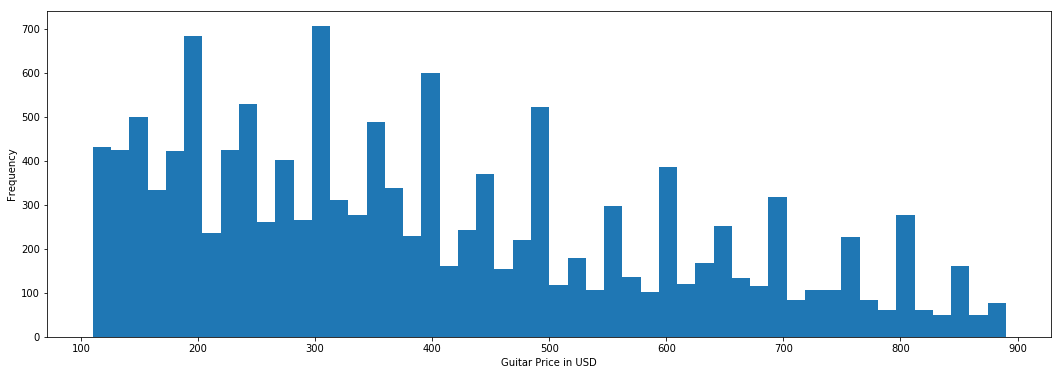

In [11]:
plt.figure(figsize = (18,6))
plt.hist(orig_prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

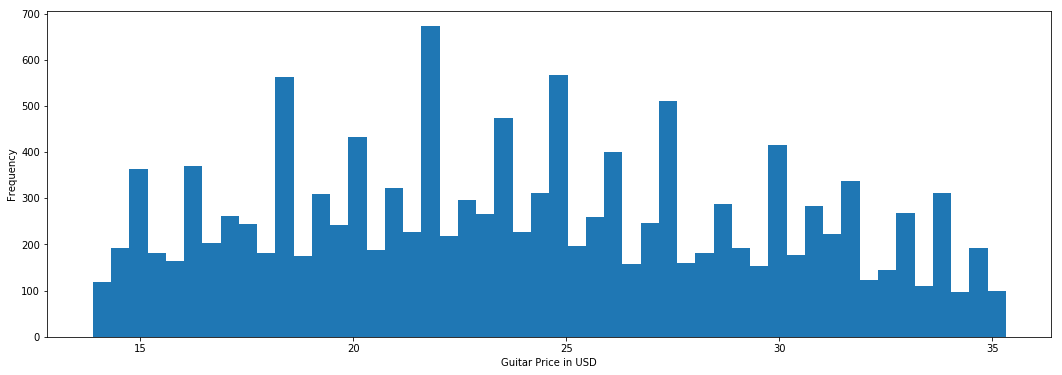

In [12]:
# prices = pd.Series([axe.price_usd for axe in axes])

prices = pd.Series(boxcox([axe.price for axe in axes], lmbda=.4), name = 'price')

plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

Some of the most expensive guitars:

In [13]:
spensive = [{'name':axe.title,
             'price': axe.price,
            'year':axe.year} for axe in axes]
sorted(spensive, key=itemgetter('price'))[-5:]

[{'name': 'Ibanez RG7-620 Dark Adriatic Blue 2000 Made in Japan',
  'price': 889.0,
  'year': 2000},
 {'name': 'Carvin NS-1 Chambered Solid Body MiDI Synth Electric Guitar NAMM DEMO',
  'price': 889.0,
  'year': 2010},
 {'name': 'Gibson SG Standard Translucent Black 2015 With Hard Case',
  'price': 889.0,
  'year': 2015},
 {'name': '2017 The Edge custom usa stratocaster AAAAA flame neck',
  'price': 889.0,
  'year': 2017},
 {'name': 'GRECO ELECTRIC GUITAR 1976 EG700T Sunburst No Pickguard With Case From Japan F/S',
  'price': 889.99,
  'year': 1976}]

**********

__Text Fields, for NLP:__

Listing Title:

In [14]:
[axe.title for axe in axes][:20] # All listings must have a title

['(MA5) Epiphone Les Paul Standard Right Handed 6 String Electric Guitar ',
 '2007 Gibson Melody Maker W/Case FREE SHIPPING!!',
 'Fender Squier Classic Vibe 50s Telecaster Maple - Vintage Blonde Mint Condition',
 'left handed fender stratocaster guitar',
 'Jackson Pro Series Misha Mansoor Juggernaut HT7FM Oceanburst Guitar Mint 2017',
 'Used - Epiphone G-1275 Double Neck Cherry Red Guitar with Case - NO RESERVE',
 'EPIPHONE By Gibson FLYING V ‘58 Korina Re-Issue Electric Guitar w/ HSC!',
 'Ibanez RG655-GK RG Prestige 500 Series HSH Electric Guitar w/ Tremolo ',
 'Ltd mh 201',
 'Ibanez JEM/UV JEMJR JEMJRWH Electric Guitar',
 'EVH Wolfgang Standard, Yellow',
 'Squier Vintage Modified Mustang Electric Guitar - Fiesta Red SKU#1074166',
 'B.C. Rich Kerry King Signature V 2 Tribal 6 String Electric Guitar w/Kahler Trem',
 '2016 Hamer Sunburst Archtop  Trans-Black Flame   w/Original Case BLOWOUT AUCTION',
 'Dean Dimebag Explosion Razorback Electric Guitar + Hard Case + Strap',
 'Squier by Fen

Mean Length of Title:

In [15]:
mean_title_len = sum(len(axe.title) for axe in axes)/len(axes)
print(f'{round(mean_title_len)} characters per title on average.')

58 characters per title on average.


In [16]:
print(f'{round(sum(1 for axe in axes if len(axe.title) < 46) / len(axes)*100,2)}% of listings have less than 46 characters in the title.')

25.62% of listings have less than 46 characters in the title.


Maybe "title has length less than 46 characters" should be a one-hot variable.

### Check for  "For parts" "as-is" etc

Listing __Sub__titles:

In [17]:
[axe.subtitle for axe in axes if axe.subtitle != None][-5:]

['Bennett Malibu converted to a Prs copy of the silversky',
 '90 DAYS WARRANTY!! 30 DAYS RETURN POLICY!!',
 'Telecaster OC Duff',
 'gibson',
 '2006 Am Deluxe Strat, 9.5" Maple Neck, PREFECT Cond! ']

In [18]:
print(f'{round(((len([axe.subtitle for axe in axes if axe.subtitle != None]) / len(axes))*100),2)}% of listings include a subtitle.')

2.2% of listings include a subtitle.


Condition Descriptions:

In [19]:
[axe.condition_description for axe in axes if axe.condition_description != None][-5:]

['Works Great!',
 'This is a used guitar with small scratches from normal play',
 'Please READ entire ad, see pics for condition, and ask ALL questions BEFORE purchase! Thanks!',
 'Very Rare Vintage 1971 EPIPHONE WILSHIRE ET-275 Made in JAPAN. Good Condition. Sounds Great !',
 'In good condition with a couple of issues: The S1 switch is not functioning; gig bag has a smokey odor to it. Please see the photos above; they are of the actual item for sale.']

In [20]:
print(f'{round(((len([axe.condition_description for axe in axes if axe.condition_description != None]) / len(axes))*100),2)}% of listings include a condition description.')

32.95% of listings include a condition description.


Example of Description Full Text:

In [21]:
print([axe.description for axe in axes][199:202])

['What the heck? Check out this ultra-groovey Brian May custom creation! I don\'t know the original make of this instrument...somebody very talented has created a highly customized one-of-a-kind rock n\' roll bumblebee that plays like a dream. Normally, cool or quirky guitars are simply that - cool and quirky (but usually not fun to play), but this little minx is just the opposite. This guitar is quality throughout. 3 Telecaster pickups were used to replace whatever was there to begin with, a Bigsby-style tremolo was added, and an awesome roller bridge was swapped in. The neck feels wonderful...dead straight with super low action; rosewood capped, 24 frets (with a zero fret, which I love). The 24" scale, unique to Brian May\'s "Red Special" is replicated here, allowing you to bend to the moon and back. The roller bridge an a graphite nut keep this baby in tune regardless of how wildly you feel like playing. The combination of on/off and phase switches gives this guitar an incredible ra

In [22]:
print(f'{round(((len([axe.description for axe in axes if axe.description != None]) / len(axes))*100),2)}% of listings include a text description.')

99.3% of listings include a text description.


***********

__Number of Pics on eBay listing:__

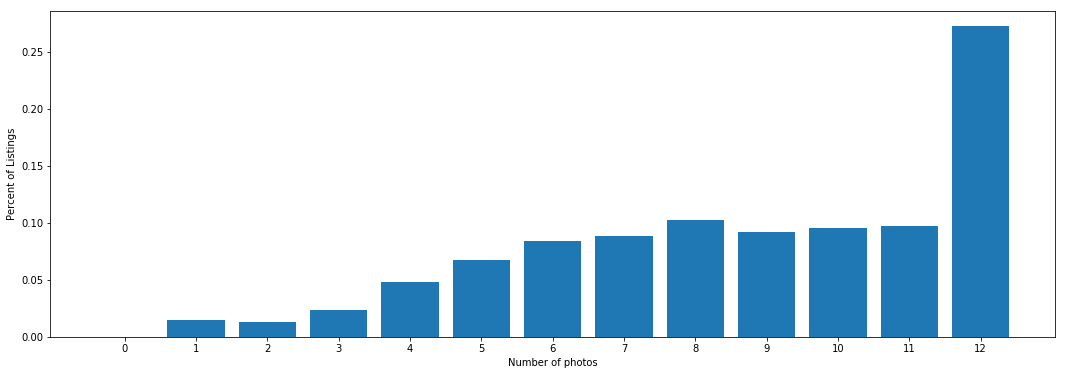

In [23]:
pic_quants = pd.Series([axe.pic_quantity for axe in axes]).value_counts()
plt.figure(figsize = (18,6))
plt.bar(pic_quants.index, pic_quants.values/len(axes))
plt.xticks(pic_quants.index)
plt.xlabel("Number of photos")
plt.ylabel("Percent of Listings")
plt.show()

In [24]:
for num_photos in range(13,0,-1):
    print(f'{round(len([axe.pic_quantity for axe in axes if axe.pic_quantity < num_photos]) / len(axes) * 100, 1)}% of auctions have less than {num_photos} photos.')

100.0% of auctions have less than 13 photos.
72.7% of auctions have less than 12 photos.
63.0% of auctions have less than 11 photos.
53.5% of auctions have less than 10 photos.
44.3% of auctions have less than 9 photos.
34.0% of auctions have less than 8 photos.
25.2% of auctions have less than 7 photos.
16.8% of auctions have less than 6 photos.
10.1% of auctions have less than 5 photos.
5.2% of auctions have less than 4 photos.
2.8% of auctions have less than 3 photos.
1.5% of auctions have less than 2 photos.
0.0% of auctions have less than 1 photos.


__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [25]:
[axe.pic for axe in axes][:5] # Just first five. You get it

['http://thumbs1.ebaystatic.com/m/mtAcVUQtaORbWJGOuh_RrVw/140.jpg',
 'http://thumbs3.ebaystatic.com/m/mK_-iu9szjIbgWCZpbHOayg/140.jpg',
 'http://thumbs4.ebaystatic.com/m/m7BR68Scura4H_JZnNkQA8g/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mUxjdbW4oMkfb40YoK6QzjA/140.jpg',
 'http://thumbs2.ebaystatic.com/m/mmU4HTGndeKx_v93C-qIj2Q/140.jpg']

**********

**Shipping Type:**

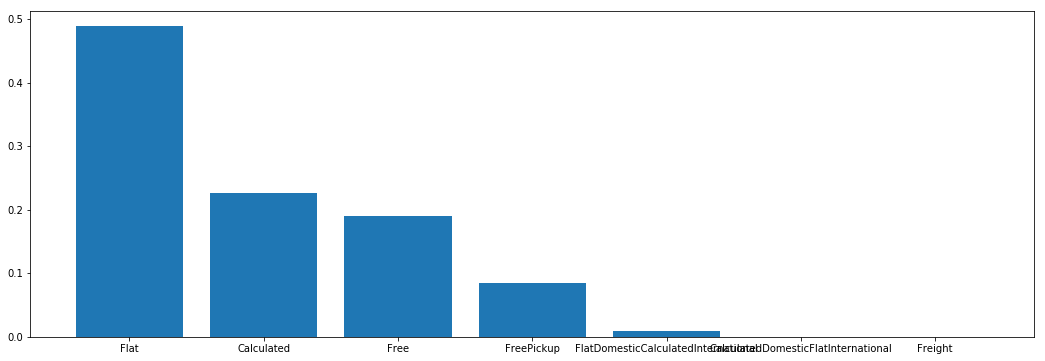

In [26]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([axe.ship_type for axe in axes]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(axes))
plt.show()

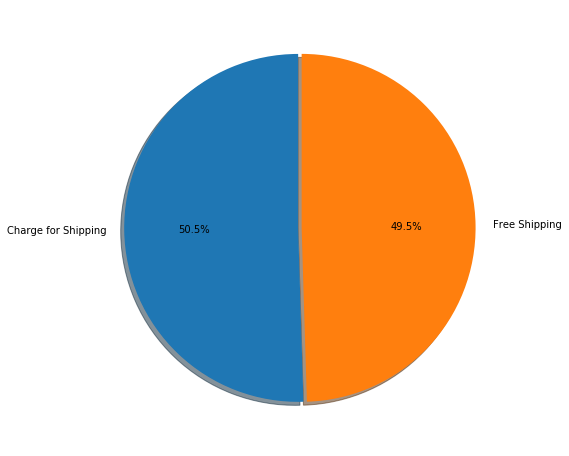

In [27]:
free = pd.Series([axe.price_shipping == 0 for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(free.values, explode=[.01,.01], labels=['Charge for Shipping', 'Free Shipping'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

In [28]:
print(f'${round(sum(axe.price_shipping for axe in axes) / len([axe.price_shipping for axe in axes]),2)} - Average shipping cost (including free shipping)')

$24.61 - Average shipping cost (including free shipping)


In [29]:
print(f'${round(sum(axe.price_shipping for axe in axes if axe.price_shipping != 0) / len([axe.price_shipping for axe in axes if axe.price_shipping]),2)} - Average shipping cost (if charging for shipping)')

$49.7 - Average shipping cost (if charging for shipping)


**Offering Expedited Shipping:**

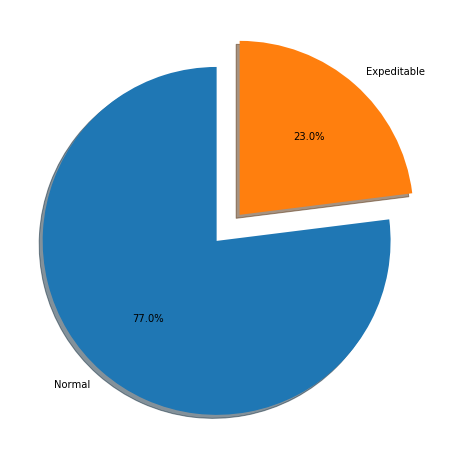

In [30]:
exp = pd.Series([axe.ship_expedite for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(exp.values, explode=[.1,.1], labels=['Normal', 'Expeditable'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__Listing Types:__

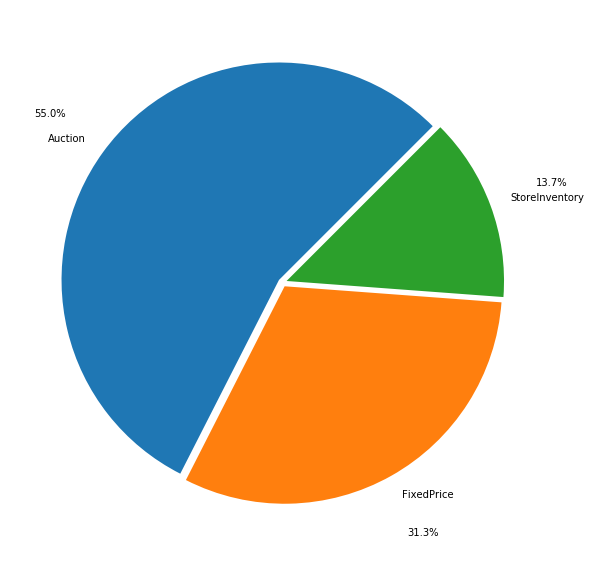

In [31]:
listing_types = pd.Series([axe.listing_type for axe in axes if axe.listing_type != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(listing_types.values, 
        labels = listing_types.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=45,
        explode = np.full(len(listing_types), .02))
plt.show()

****

__TEMPORAL STUFF__

**Handling Time in Days:**

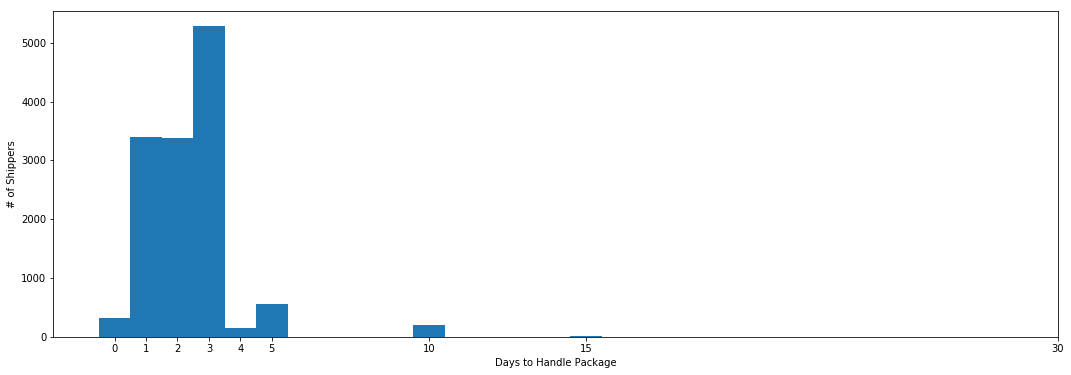

In [32]:
plt.figure(figsize = (18,6))
times = pd.Series([axe.ship_handling_time for axe in axes if axe.ship_handling_time != None])
plt.hist(times, bins=np.arange(max(times))-.5)
plt.xticks(sorted(times.value_counts().index))
plt.xlabel('Days to Handle Package')
plt.ylabel('# of Shippers')
plt.show()

__Duration of Auction in Days__:

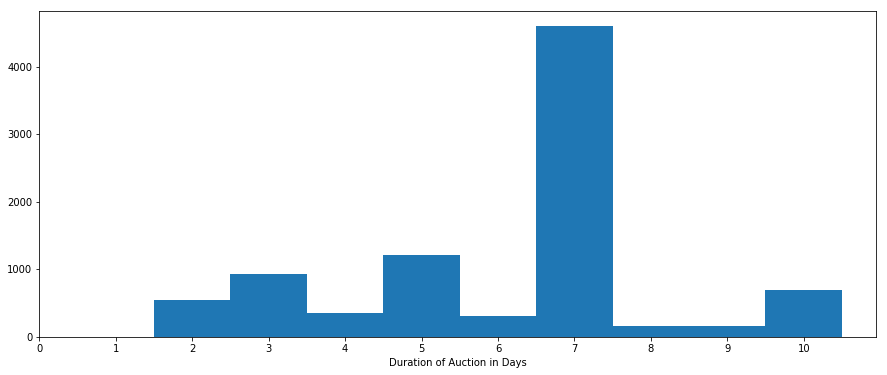

In [33]:
plt.figure(figsize = (15,6))
plt.hist([axe.duration/24 for axe in axes], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Duration of Auction in Days')
plt.show()

**Weekday of Auction Start:**

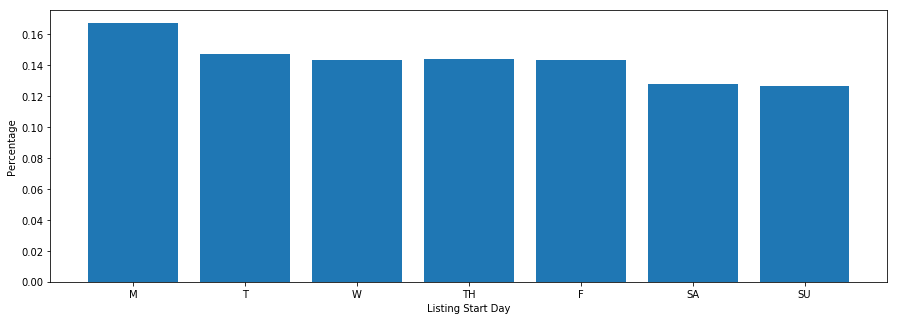

In [34]:
days = pd.Series([axe.start_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Weekday of Auction End:**

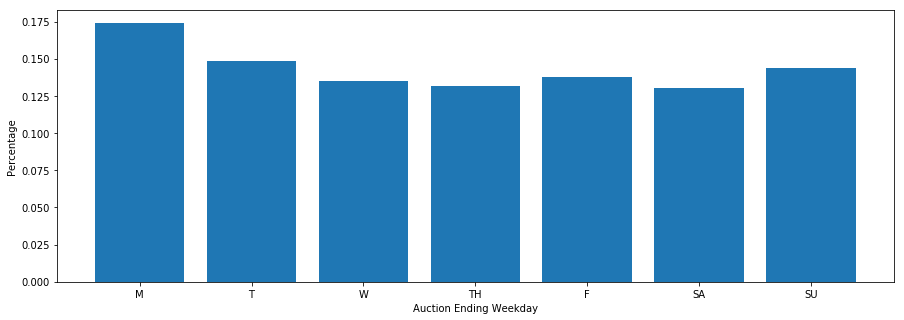

In [35]:
days = pd.Series([axe.end_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

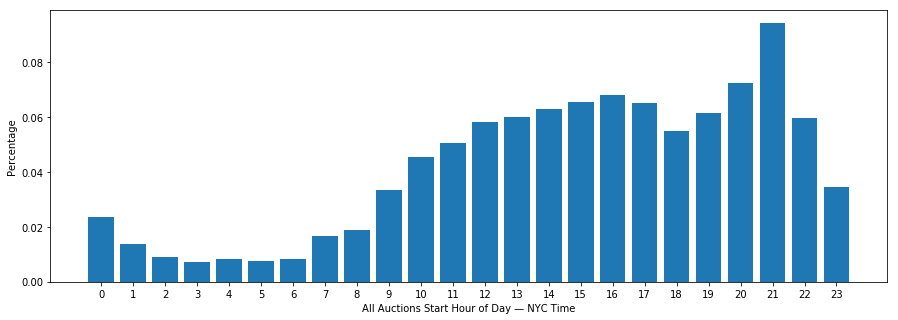

In [36]:
start_hours = pd.Series([axe.start_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((start_hours.index-5+24)%24, start_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions Start Hour of Day — NYC Time")
plt.show()

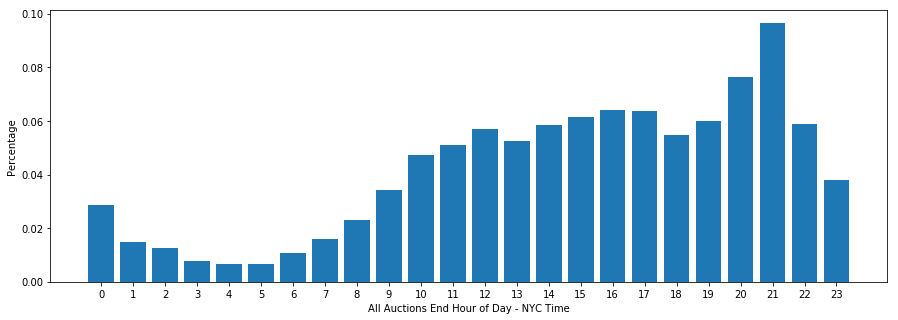

In [37]:
end_hours = pd.Series([axe.end_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((end_hours.index - 5 + 24)%24, end_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions End Hour of Day - NYC Time")
plt.show()

**Percentage of Auctions Offering Returns:**

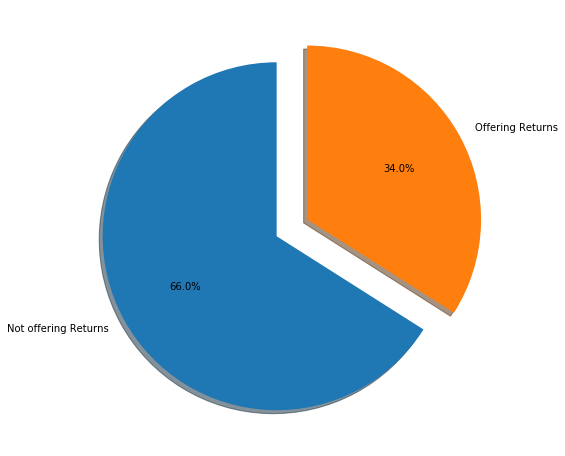

In [38]:
returns = pd.Series([axe.returns for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(returns.values, explode=[.1,.1], labels=['Not offering Returns', 'Offering Returns'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Return Time Window** (of those offering returns):

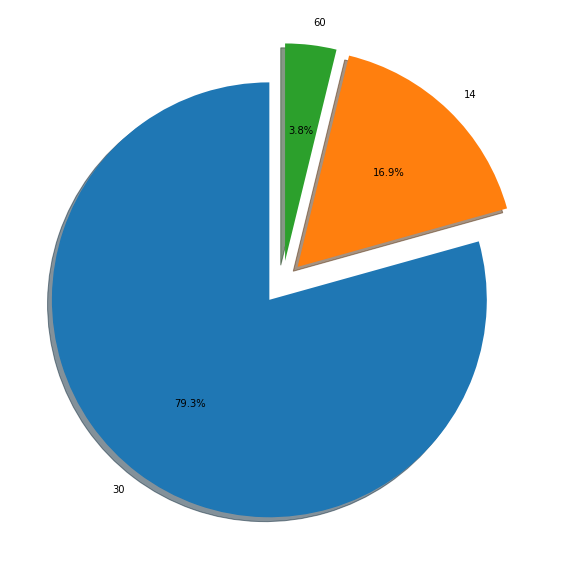

In [39]:
returns = pd.Series([axe.returns_time for axe in axes if axe.returns_time > 0]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(returns.values, explode=np.full(len(returns), .1), labels = returns.index, 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Offering AutoPay:**

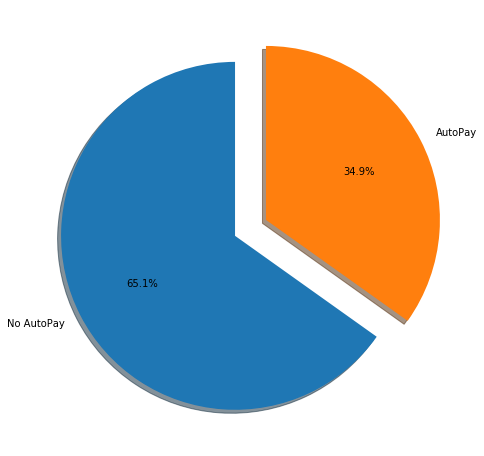

In [40]:
auto = pd.Series([axe.autopay for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(auto.values, explode=[.1,.1], 
        labels=['No AutoPay', 'AutoPay'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__"Best Offer":__

In [41]:
print(f'{round((sum(axe.best_offer_enabled for axe in axes) / len(axes)*100),2)}% of listings have "Best Offer" enabled. (Potential buyers are allowed to negotiate price)')

39.72% of listings have "Best Offer" enabled. (Potential buyers are allowed to negotiate price)


***

**Countries of Sellers:**

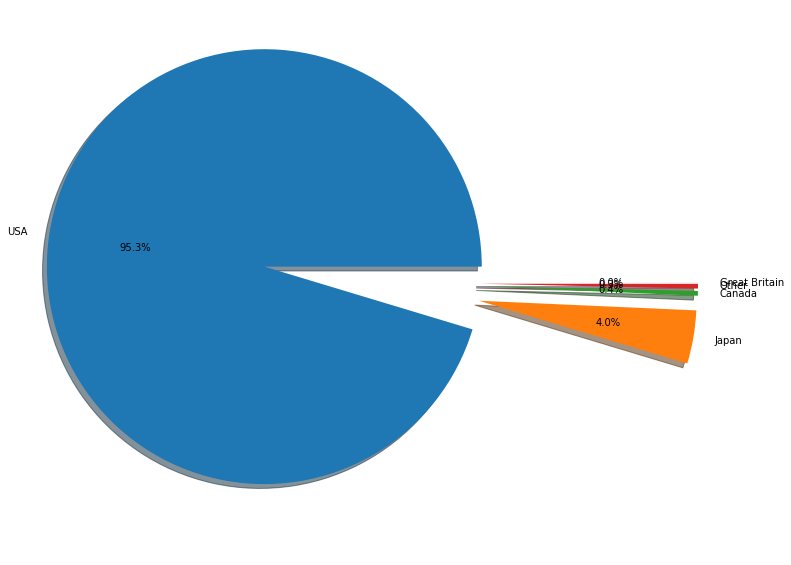

In [42]:
plt.figure(figsize = (10,10))
countries = pd.Series([axe.country_seller for axe in axes]).value_counts()
plt.pie(countries.values, labels=['USA', 'Japan', 'Canada', 
                                  'Other','Great Britain'], 
                            explode = np.full(len(countries), .5), 
        autopct='%1.1f%%',
       shadow = True)
plt.show()

__Seller Karma:__

Ebay Seller Feedback Score:

/Users/rob/.local/share/virtualenvs/GuitArbitrage-FeU9o7ga/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rob/.local/share/virtualenvs/GuitArbitrage-FeU9o7ga/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


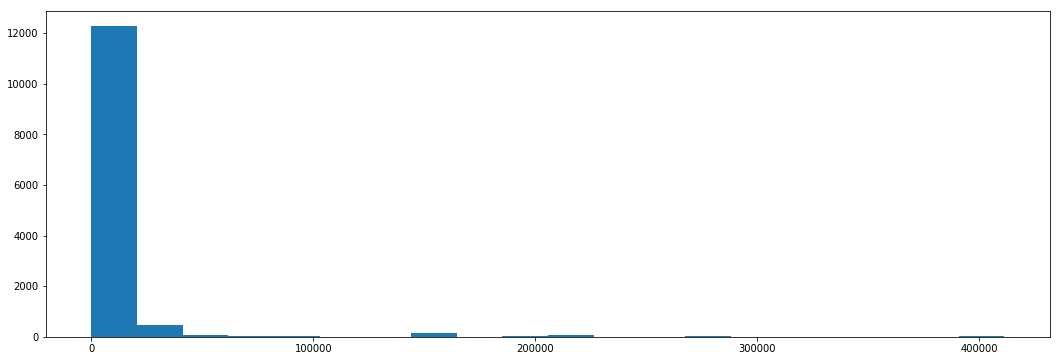

In [43]:
scores = pd.Series([axe.seller_feedback_score for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

In [44]:
scores.min(), scores.max()

(-2.0, 411524.0)

eBay Positive Feedback Percentage:

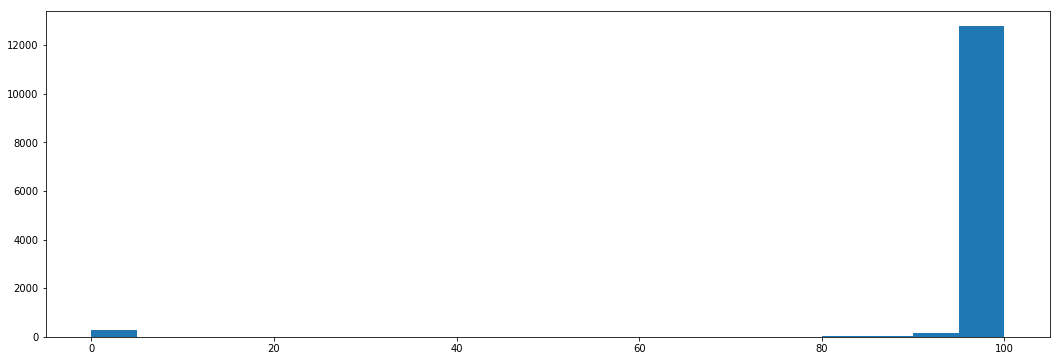

In [45]:
scores = pd.Series([axe.seller_positive_percent for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

***

__Guitars: Countries of Manufacture:__

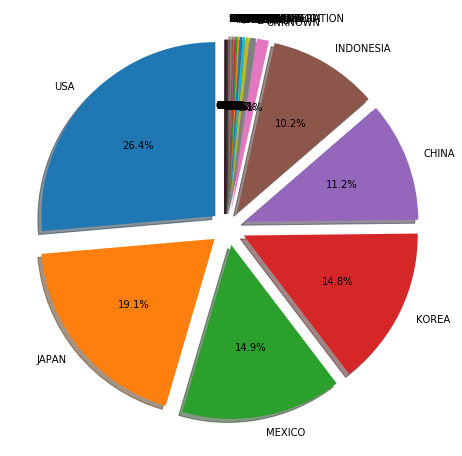

In [46]:
plt.figure(figsize = (8,8))
countries = pd.Series([axe.country_manufacture for axe in axes]).value_counts()
plt.pie(countries.values, labels= countries.index, explode = np.full(len(countries), .1), 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

In [47]:
per = round(sum(pd.Series(len([axe.country_manufacture for axe in axes if axe.country_manufacture != None]) / len(axes))*100),2)
print(f'{per}% of auctions list a country of manufacture where they\'re supposed to.')

31.43% of auctions list a country of manufacture where they're supposed to.


***

__Guitar Body Colors:__

In [48]:
colors = pd.Series([axe.color for axe in axes if axe.color != None]).value_counts()
colores = list(colors.index)
colores[2] = 'ORANGE'
colores[3] = 'PINK'
colores[4] = 'BEIGE'
colores[5] = 'TAN'
# colores

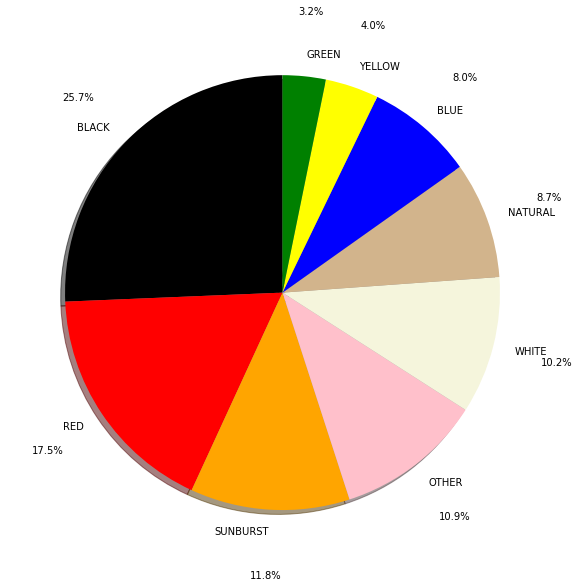

In [49]:
plt.figure(figsize = (10,10))
plt.pie(colors.values, labels=colors.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       shadow = True,
       startangle=90,
       colors = colores)
plt.show()

In [50]:
per = round(len([axe.color for axe in axes if axe.color != None]) *100 / len(axes), 2)
print(f'{per}% of auctions list a body color where they\'re supposed to.')

56.59% of auctions list a body color where they're supposed to.


***

__Age of Guitars:__

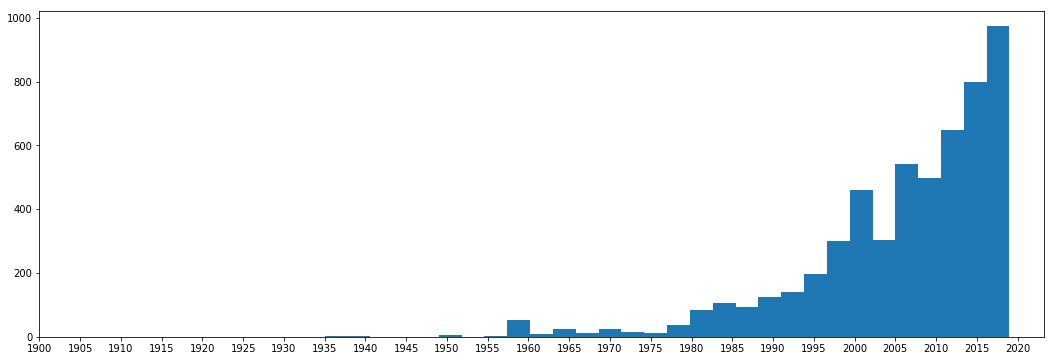

In [51]:
years = pd.Series([axe.year for axe in axes if axe.year != None])
plt.figure(figsize = (18,6))
plt.hist(years, bins=30)
plt.xticks(np.arange(1900,2021,5))
plt.show()

In [52]:
print(f'{round((len(years) / len(axes) * 100),2)}% of auctions include year data...')

41.13% of auctions include year data...


### What if we just bin years, drawing the line where it really matters?

***

__US Seller Locations, by Zip Code:__

In [53]:
sales = [(axe.zip[0], axe.start_time) for axe in axes if axe.country_seller == 'US' and axe.zip != None]

In [54]:
def get_usa_zips(url):
    usa_zips = {}
    census_zip_latlon = io.StringIO(requests.get(url).text)
    dialect = csv.Sniffer().sniff(census_zip_latlon.read(1024))
    census_zip_latlon.seek(0)
    reader = csv.reader(census_zip_latlon, dialect)
    for row in reader:
        usa_zips[row[0]] = (row[1], row[2])
    return usa_zips

In [55]:
usa_zips = get_usa_zips(r'https://goo.gl/oYwpRM')

In [56]:
sales = [sale for sale in sales if sale[1] > datetime.strptime('2018-08-01', '%Y-%m-%d')]

In [57]:
def write_kepler_csv():
    with open('../_for_kepler.csv', mode='w') as sale_lat_long_datetime_file:

        sales_writer = csv.writer(sale_lat_long_datetime_file, delimiter=',', 
                                                           quotechar='"', 
                                                           quoting=csv.QUOTE_MINIMAL)

        ## The sample data set I got from the kepler github repo had rows named like so:
        sales_writer.writerow(['latitude','longitude','tpep_sale_datetime'])
        omissions = 0
        
        for sale in sales:
            try:
                datetime = sale[1]
                lat = usa_zips[sale[0]][0]
                lon = usa_zips[sale[0]][1]
                sales_writer.writerow([lat, lon,datetime])
            except KeyError:
                omissions += 1
        print (f"{round((omissions/len(sales))*100, 2)}% of zips were not found")

In [58]:
write_kepler_csv()

0.86% of zips were not found


***

__Guitar Brands__

In [59]:
brand_counts = pd.Series([axe.brand for axe in axes]).value_counts()

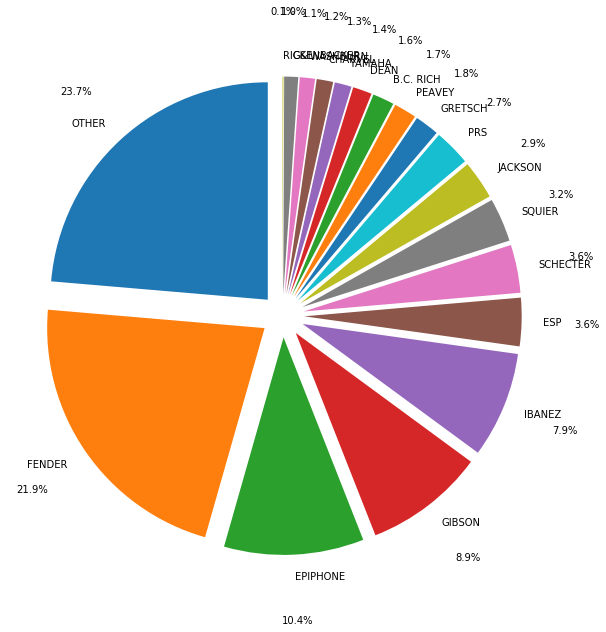

In [60]:
plt.figure(figsize = (10,10))
plt.pie(brand_counts.values, 
        labels = brand_counts.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=90,
        explode = np.full(len(brand_counts), .1))
plt.show()

In [61]:
print(f'{round((len([axe.brand for axe in axes if axe.brand != None]) * 100 / len(axes) ),2)}% of auctions include brand data.')

93.72% of auctions include brand data.


**Individual Guitar Models**

In [62]:
model_counts = pd.Series([axe.model for axe in axes if axe.brand != None]).value_counts()

There is such a great variety of guitar models. Slivers of the pie smaller than "SQUIER" (rightmost tiny sliver) have been lumped into "OTHER".

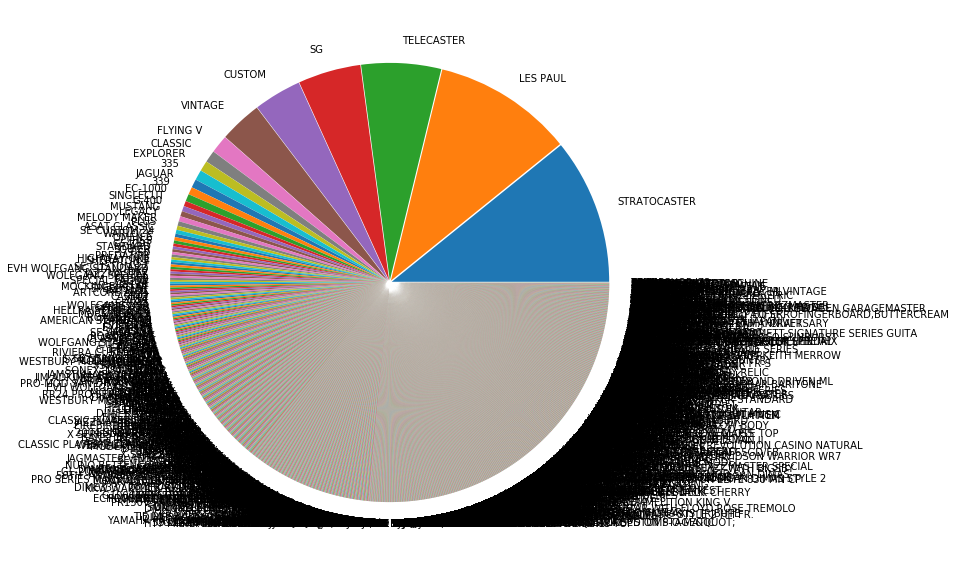

In [63]:
plt.figure(figsize = (10,10))
plt.pie(model_counts.values, labels = model_counts.index,
                            explode = np.full(len(model_counts), .01))
plt.show()

***

__Right or Left Handed:__

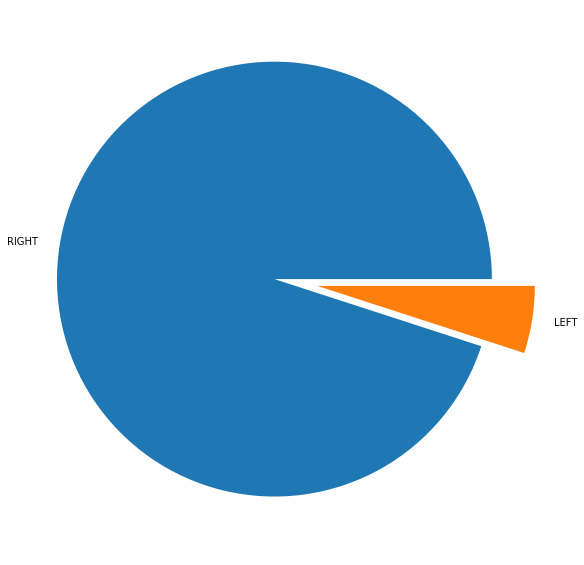

In [64]:
RL = pd.Series([axe.right_left_handed for axe in axes if axe.right_left_handed != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(RL.values, labels = RL.index,
                            explode = np.full(len(RL), .1))
plt.show()

In [65]:
print(f'{round((len([axe.right_left_handed for axe in axes if axe.right_left_handed != None]) / len(axes)),2)}% of auctions include dexterity.')

0.4% of auctions include dexterity.


***

__Body Types:__

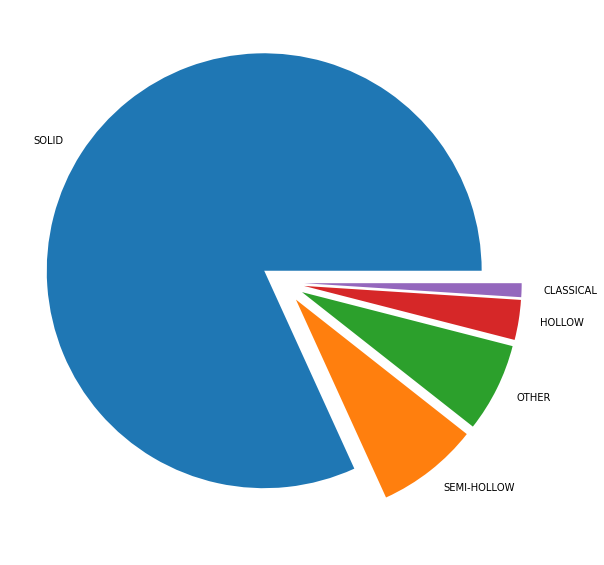

In [66]:
plt.figure(figsize=(10,10))
bodies = pd.Series([axe.body_type for axe in axes if axe.body_type != None]).value_counts()
plt.pie(bodies.values, 
        labels = bodies.index,
       explode = np.full(len(bodies), .1))
plt.show()

In [67]:
print(f'{sum(bodies.values)} aka {round(sum(bodies.values) / len(axes) * 100, 2)}% of listings provide a body type.')

7209 aka 54.18% of listings provide a body type.


****

__Number of Strings:__

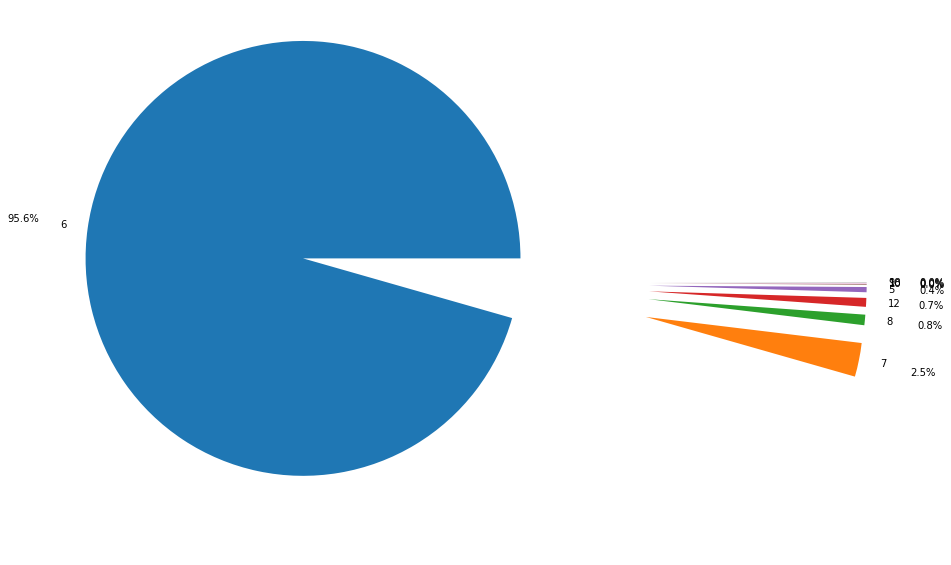

In [68]:
strings = pd.Series([axe.string_config for axe in axes if axe.string_config != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(strings.values, 
        labels = strings.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=0,
        explode = np.full(len(strings), .8))
plt.show()

In [69]:
print(f'{sum(strings.values)} aka {round(sum(strings.values) / len(axes) * 100, 2)}% of listings provide a string count.')

8090 aka 60.8% of listings provide a string count.
